# AutoETS

AutoETS (Auto Exponential Smoothing) is an automatic forecasting method that applies exponential smoothing to time series data with trend and seasonality.

**Key Ideas**  
- Automatically selects the best exponential smoothing model based on information criteria (AIC, AICC or BIC).
- Provides point, variance, quantile, interval and distribution forecasts.
- Can be used with different types of seasonality or no seasonality at all.
- sktime package: provide multiple probabilistic forecasting methods and possible to implement its own custom probabilistic forecaster.

**Model documentation**: 

- github: https://github.com/sktime/sktime
- AutoETS: https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.ets.AutoETS.html
- sktime notebook proba forecasting: https://github.com/sktime/sktime/blob/main/examples/01b_forecasting_proba.ipynb
- user guide: https://www.sktime.net/en/v0.19.2/examples/01b_forecasting_proba.html
- guide to build your own probabilistic forecaster: https://www.sktime.net/en/stable/developer_guide/add_estimators.html

**Requirements:**

!pip install sktime

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.visualization.viz_predictions import plot_dove_predictions
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.datasources.livedata import live_data_generator

from birdgame.visualization.viz_autoets import visualize_sktime_model
from birdgame.visualization.viz_predictions import plot_dove_predictions
from birdgame.evaluation.normal_dist import compute_score_for_normal_dist
from birdgame.evaluation.utils import find_past_pdf, summarize_predictions

### Warm up example: AutoETS

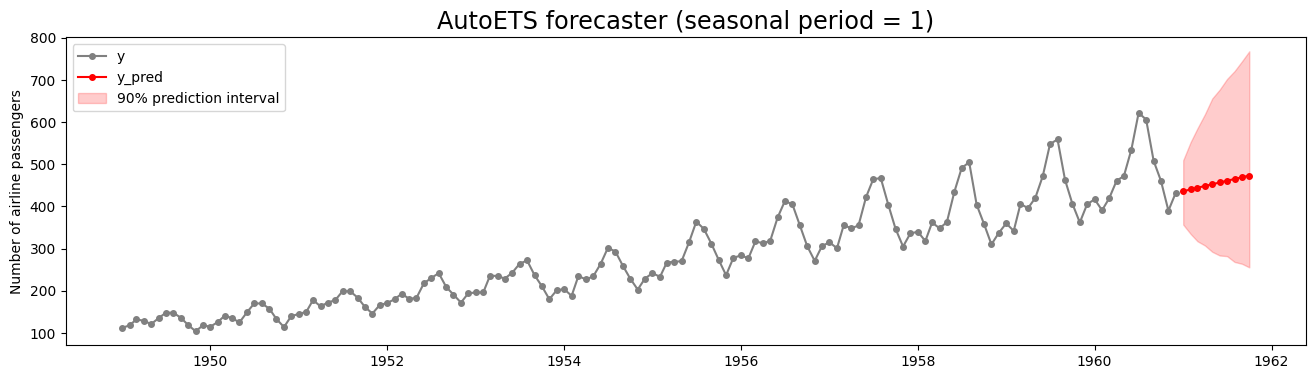

Variance estimation:


,Number of airline passengers
1961-01,2369.515115
1961-02,3915.239156
1961-03,6224.231802
1961-04,7784.997968
1961-05,9813.652025
1961-06,11128.922667
1961-07,12784.400996
1961-08,15377.842962
1961-09,18143.251621
1961-10,21340.906184


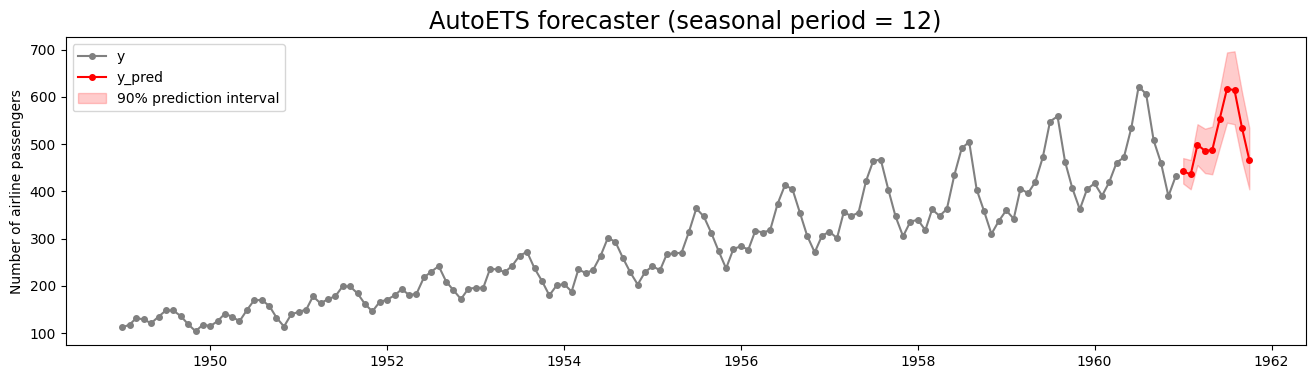

Variance estimation:


,Number of airline passengers
1961-01,234.769060
1961-02,332.473924
1961-03,664.742186
1961-04,771.004827
1961-05,953.077965
1961-06,1357.918048
1961-07,2157.792188
1961-08,2492.150332
1961-09,2165.345888
1961-10,1731.039908


In [2]:
# Run AutoETS sktime model for different seasonal period
for sp in [1, 12]:
    visualize_sktime_model(seasonal_period=sp)

In [3]:
from birdgame.trackers.trackerbase import TrackerBase
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sktime.forecasting.arima import AutoARIMA

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
    

class AutoETSsktimeTracker(TrackerBase):
    """
    A model that tracks the dove location using AutoETS.

    Parameters
    ----------
    horizon : int
        The "look-ahead" in time after which the recorded data becomes valid for updating.
    train_model_frequency : int
        The frequency at which the sktime model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the sktime model.
    """

    def __init__(self, horizon=10, train_model_frequency=100, num_data_points_max=20):
        super().__init__(horizon)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.prev_t = 0

        self.train_model_frequency = train_model_frequency
        self.num_data_points_max = num_data_points_max

        # Number of steps to predict
        steps = 1 # only one because the univariate serie will only have values separated of at least HORIZON time
        self.fh = np.arange(1, steps + 1)

        # Fit the AutoETS forecaster (no seasonality)
        self.forecaster = AutoETS(auto=True, sp=1, information_criterion="aic")

        # or Fit the AutoARIMA forecaster
        # self.forecaster = AutoARIMA(max_p=2, max_d=1, max_q=2, maxiter=10)
        
    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the
        estimated Gaussian mixture model.

        The core distribution captures regular variance, while the tail distribution
        captures extreme deviations.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """
        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x

        # we build a univariate serie of values separated of at least HORIZON time
        if t > self.prev_t + self.horizon:
            self.last_observed_data.append(x)
            self.prev_t = t

        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            if self.count > 10 and self.count%self.train_model_frequency == 0:
                # Construct 'y' as an univariate serie
                y = np.array(self.last_observed_data)[-self.num_data_points_max:]

                # Fit sktime model
                self.forecaster.fit(y, fh=self.fh)

                # Variance prediction
                var = self.forecaster.predict_var(fh=self.fh)
                self.scale = np.sqrt(var.values.flatten()[-1])

                # Update last observed data
                self.last_observed_data = self.last_observed_data[-(self.num_data_points_max + 2):]
            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.
        """
        # the central value (mean) of the gaussian distribution will be represented by the current value
        x_mean = self.current_x
        components = []

        try:
            # here we use current value as loc but you can get point forecast from 'self.forecaster.predict(fh=self.fh[-1])[0][0]'
            loc = x_mean

            # we predicted scale during tick training
            scale = self.scale
            scale = max(scale, 1e-6)

            # If you want to predict variance for each prediction
            # scale = self.forecaster.predict_var(fh=self.fh)
            # scale = np.sqrt(scale.values.flatten()[-1])
        except:
            loc = x_mean
            scale = 1e-6

        # Return the prediction density
        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }

        return prediction_density

### Model experimentation

The model is experimented on a data generator using the following metric:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    HORIZON = 10
    TRAIN_MODEL_FREQUENCY=50
    NUM_DATA_POINTS_MAX=20
    MAX_TRACKER_COUNT = 10000
    SHOW_PRINT = True
    STEP_PRINT = 1000
    METRIC = "pdf_score"

# Initialize Tracker
tracker = AutoETSsktimeTracker(horizon=Constants.HORIZON, train_model_frequency=Constants.TRAIN_MODEL_FREQUENCY, 
                               num_data_points_max=Constants.NUM_DATA_POINTS_MAX)


# History to track evaluation metrics and the PDFs
score_history = []
pdf_history = []
store_pred = []

# Start Processing Data
start_time = time.time()
data_generator = remote_test_data_generator()

for payload in tqdm(data_generator, position=0, leave=True):
    tracker.tick(payload)
    pdf = tracker.predict()
    current_time = payload['time']

    # Store the latest PDF prediction
    pdf_history.append((current_time, pdf))

    # Find past PDF predicition for evaluation
    past_pdf = find_past_pdf(pdf_history, current_time, Constants.HORIZON)

    if past_pdf:
        observed_dove_location = payload['dove_location']
        weighted_pdf_score, prediction_info = compute_score_for_normal_dist(past_pdf, observed_dove_location, metric=Constants.METRIC)

        # Store results
        score_history.append(weighted_pdf_score)
        prediction_info["time"] = current_time
        store_pred.append(prediction_info)

        if Constants.SHOW_PRINT and len(pdf_history) % Constants.STEP_PRINT == 0:
            print(
                f"[{tracker.count}] {Constants.METRIC}: {weighted_pdf_score:.4f} / true: {observed_dove_location:.4f} / "
                f"pred: {prediction_info["loc"]:.4f} / dif: {observed_dove_location - prediction_info["loc"]:.4f} / "
                f"scale: {prediction_info["scale"]:.4f}"
            )
    else:
        if Constants.SHOW_PRINT:
            print(f"[{tracker.count}] No valid past PDF for evaluation.")

    if tracker.count > Constants.MAX_TRACKER_COUNT:
        break

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

0it [00:00, ?it/s]

[0] No valid past PDF for evaluation.
[0] No valid past PDF for evaluation.
[368] pdf_score: 3.1920 / true: 8396.0902 / pred: 8396.1007 / dif: -0.0105 / scale: 0.0040
[726] pdf_score: 33.7840 / true: 8395.4667 / pred: 8395.4600 / dif: 0.0068 / scale: 0.0054
[1061] pdf_score: 10.2350 / true: 8395.8812 / pred: 8395.8787 / dif: 0.0025 / scale: 0.0389
[1449] pdf_score: 22.1900 / true: 8395.0469 / pred: 8395.0548 / dif: -0.0079 / scale: 0.0049
[1819] pdf_score: 41.9950 / true: 8395.6477 / pred: 8395.6440 / dif: 0.0037 / scale: 0.0087
[2213] pdf_score: 7.6660 / true: 8395.7813 / pred: 8395.7502 / dif: 0.0311 / scale: 0.0353
[2553] pdf_score: 56.2660 / true: 8395.7586 / pred: 8395.7586 / dif: 0.0000 / scale: 0.0071
[2929] pdf_score: 12.2800 / true: 8395.0275 / pred: 8395.0296 / dif: -0.0021 / scale: 0.0324
[3319] pdf_score: 0.0000 / true: 8394.8244 / pred: 8394.9810 / dif: -0.1566 / scale: 0.0166
[3640] pdf_score: 40.4790 / true: 8395.1889 / pred: 8395.1937 / dif: -0.0048 / scale: 0.0032
[401

### Prediction summary

In [5]:
skip_length = 500
# Display scores and predictions (skipping first 500 values -> skip warmup of model)
stats_summary, pred_summary = summarize_predictions(score_history, store_pred, skip_length=500)

Median: {'score': 19.942}
Mean: {'score': 25.838}
Std: {'score': 24.101}

Prediction Data:


,loc,scale,dove_location,score,time
0,8396.52633,0.00869,8396.52999,42.01160,102671.0
1,8396.53112,0.00869,8396.51211,4.20309,102672.0
2,8396.53112,0.00869,8396.51211,4.20309,102674.0
3,8396.51211,0.00869,8396.51393,44.88858,102685.0
4,8396.51211,0.00869,8396.52848,7.79872,102686.0
...,...,...,...,...,...
26184,8397.59231,0.01592,8397.58851,24.35664,365278.0
26185,8397.59231,0.01592,8397.58135,19.76672,365279.0
26186,8397.59453,0.01592,8397.58135,17.78438,365285.0
26187,8397.59653,0.01592,8397.58188,16.40987,365288.0


### Visualize predictions

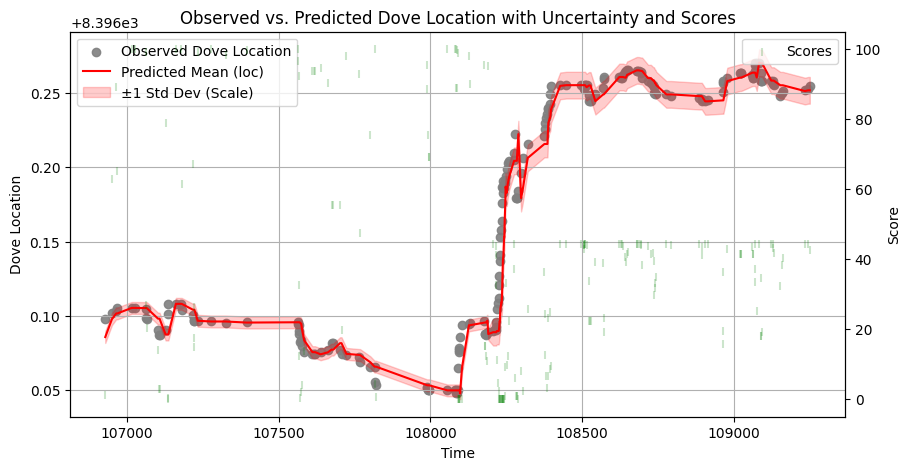

In [6]:
start_ind=1000
window_size=200
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)

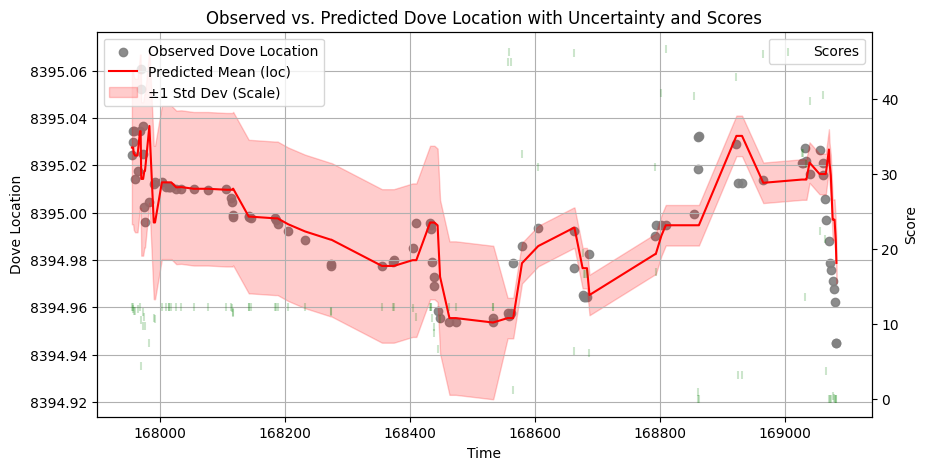

In [7]:
start_ind=8000
window_size=100
plot_dove_predictions(store_pred, start_ind=start_ind, window_size=window_size)